In [49]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 
import seaborn as sns

# загрузим данные
df = pd.read_csv("../data/segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,3
1,2,1,21.0,15.0,81.0,4
2,3,0,20.0,16.0,6.0,3
3,4,0,23.0,16.0,77.0,4
4,5,0,31.0,17.0,40.0,3


In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,customer_id,gender,age,annual_income,spending_score,cluster


In [52]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [53]:
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [54]:
import plotly
import plotly.express as px

def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [55]:
get_3d_visualization(df, None)

In [56]:
X = df[['age', 'annual_income', 'spending_score']]

In [57]:
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)

# Далее можно визуализировать результаты, как мы делали с алгоритмом k-means
get_3d_visualization(df, clustering.labels_)

Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать.

In [58]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=14, min_samples=3)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

In [59]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

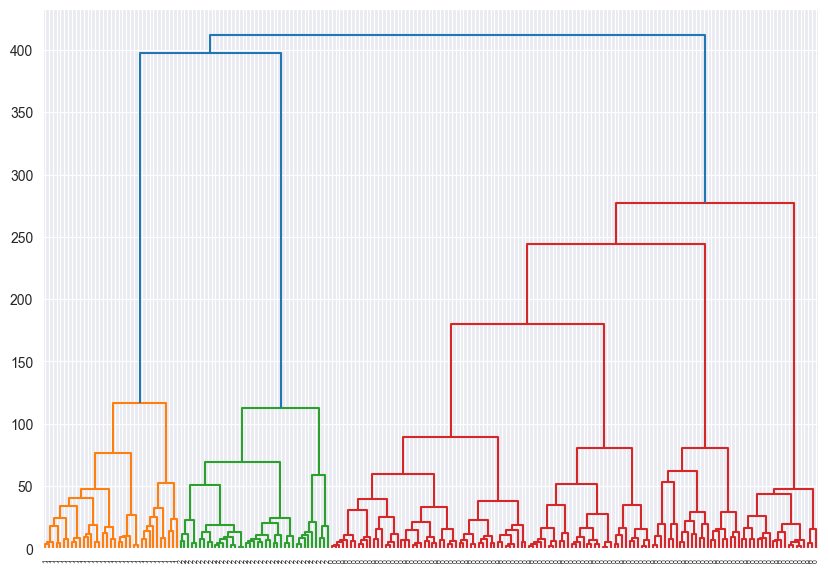

In [60]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

pred_labels = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')

plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=pred_labels,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [61]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

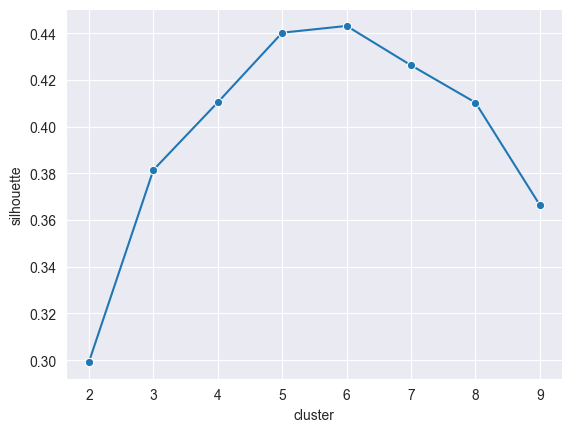

In [62]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    res = get_aggl_clustering(X, cluster_num)
    # подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, res)
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Оптимальное кол-во - 6 кластеров

In [66]:
df['res_cluster'] = get_aggl_clustering(X, 6)

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами.

In [67]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.res_cluster))

0.9858363091910892


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.